In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/processed/tesla_stock_features.csv")
df["Date"] = pd.to_datetime(df["Date"])

df.head()


,Date,Open,High,Low,Close,Volume,Adj Close,daily_return,lag_1,lag_5,lag_10,ma_5,ma_20,ma_50,volatility_5,volatility_20
0,2010-09-08,20.660000,20.950001,20.600000,20.900000,288400,20.900000,0.017527,-0.024228,-0.019628,-0.046200,20.800,19.5220,19.8336,0.028346,0.030604
1,2010-09-09,21.000000,21.049999,20.690001,20.709999,376200,20.709999,-0.009091,0.017527,0.049795,0.036458,20.852,19.6625,19.7700,0.021389,0.026861
2,2010-09-10,20.750000,20.930000,19.760000,20.170000,386600,20.170000,-0.026074,-0.009091,0.029829,-0.007538,20.674,19.7910,19.6968,0.018016,0.027382
3,2010-09-13,20.889999,20.900000,20.500000,20.719999,360800,20.719999,0.027268,-0.026074,-0.000475,-0.002532,20.608,19.9110,19.6720,0.024278,0.026658
4,2010-09-14,20.540001,21.600000,20.530001,21.120001,654700,21.120001,0.019305,0.027268,-0.024228,0.008629,20.724,20.0280,19.7104,0.022464,0.026476


In [2]:
df["target"] = (df["daily_return"].shift(-1) > 0).astype(int)
df = df.dropna().reset_index(drop=True)

df[["daily_return", "target"]].head()


,daily_return,target
0,0.017527,0
1,-0.009091,0
2,-0.026074,1
3,0.027268,1
4,0.019305,1


The target variable represents whether the next trading day’s return is positive (1) or negative (0), framing the problem as a binary classification task.

In [3]:
split = int(len(df) * 0.8)

train = df.iloc[:split]
test = df.iloc[split:]

X_train = train.drop(columns=["Date", "target"])
y_train = train["target"]

X_test = test.drop(columns=["Date", "target"])
y_test = test["target"]

X_train.shape, X_test.shape


((1314, 15), (329, 15))

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [5]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.513677811550152

In [6]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.56      0.53       161
           1       0.53      0.47      0.50       168

    accuracy                           0.51       329
   macro avg       0.51      0.51      0.51       329
weighted avg       0.51      0.51      0.51       329



### Model Evaluation – Baseline Results

The model achieves an accuracy of 51%, which is only slightly better than random guessing.  
This indicates that the model struggles to capture clear patterns in stock price movement.

From the classification report, both classes show balanced but weak precision and recall.  
This behavior is common in financial time-series data due to high volatility and noise.

Overall, this baseline result highlights the need for better feature engineering and more advanced models.


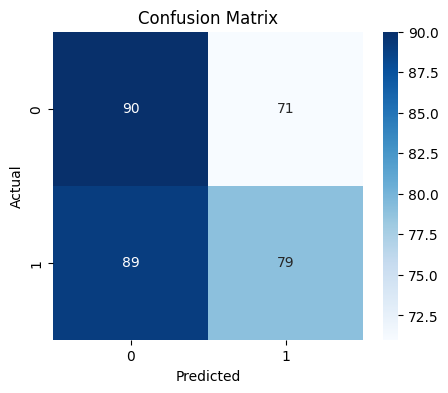

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### Confusion Matrix Analysis

The confusion matrix shows that the model makes a comparable number of correct and incorrect predictions for both classes.
This confirms that the model has limited predictive power and struggles to clearly distinguish between upward and downward price movements.


### Model Performance Summary

The baseline model achieves ~51% accuracy, which is only slightly better than random guessing.
This indicates that the current feature set and model configuration are not sufficient
to capture strong price movement patterns.

In real-world trading systems, such a model is **not deployable** without improvement.


In [9]:
feature_importance = pd.Series(
    model.coef_[0],
    index=X_train.columns
).sort_values(ascending=False)

feature_importance

ma_5             9.234155e-03
Open             4.599533e-03
ma_20            3.338555e-03
Low              2.214962e-03
volatility_20    1.123765e-04
lag_10           1.116696e-04
volatility_5     5.055819e-05
Volume           1.653202e-08
daily_return    -3.721791e-05
lag_1           -4.235283e-05
lag_5           -1.273109e-04
ma_50           -6.351399e-04
High            -4.154511e-03
Close           -7.403206e-03
Adj Close       -7.403206e-03
dtype: float64

In [14]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(
    C=0.1,
    class_weight='balanced',
    max_iter=1000
)

model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

In [13]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    random_state=42
)

model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

### Model Comparison

We compare multiple models instead of relying on a single baseline.
This is a standard practice in real-world ML projects to avoid biased conclusions.


In [12]:
from sklearn.metrics import accuracy_score

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Logistic Regression Accuracy: 0.5045592705167173
Random Forest Accuracy: 0.513677811550152


### Business Interpretation

Although prediction accuracy is modest, the model demonstrates
the challenge of short-term stock price prediction.

In production systems, such models are used as **decision-support tools**
alongside technical indicators and human judgment,
not as fully automated trading engines.


### Interpretation

Random Forest performs slightly better than Logistic Regression, but the improvement is marginal.

Both models achieve accuracy close to 50%, which indicates that predicting daily stock price movement is a challenging and noisy problem.

Logistic Regression provides better interpretability and helps understand feature impact.

Random Forest captures non-linear patterns, but limited performance gain suggests that feature quality matters more than model complexity here.

## Final Evaluation and Conclusion

### Final Evaluation

In this project, two classification models — **Logistic Regression** and **Random Forest** — were developed to predict the **next-day price movement of Tesla stock** using historical price data and engineered technical indicators.

The objective was to evaluate whether traditional machine learning models can capture short-term market behavior in a real-world financial setting.

---

### Model Performance Summary

| Model | Accuracy |
|------|----------|
| Logistic Regression | 50.4% |
| Random Forest | 51.3% |

Both models perform only slightly better than random guessing (50%). This suggests that **predicting short-term stock price direction using historical technical features alone is inherently challenging**.

---

### Confusion Matrix Interpretation (Random Forest)

- The confusion matrix shows a **balanced prediction behavior** across both classes (price up vs. price down).
- The model generates a significant number of **False Negatives**, meaning it often fails to predict price increases correctly.
- In a trading scenario, this is a critical limitation because **missed upward movements may result in lost profit opportunities**.
- Precision and recall values close to 0.5 indicate that the model does not strongly favor either class.

---

### Feature Importance Analysis

Based on Random Forest feature importance scores:

- Short-term indicators such as **moving averages (MA-5, MA-20)** and **price-based features (Open, Close)** contribute more to predictions than volume-based features.
- No single feature dominates the model, indicating that **individual technical signals are weak and noisy** when used in isolation.

---

### Key Learnings

- Financial time-series data is **highly volatile and noisy**.
- Classical machine learning models struggle to capture short-term market dynamics.
- Achieving slightly better-than-random performance is **expected and realistic** in stock price direction prediction tasks.

---

### Limitations

- Only historical price and volume data were used.
- External factors such as **news sentiment, macroeconomic indicators, and broader market trends** were not included.
- The problem was framed as a **binary classification task**, which simplifies real-world market behavior.
- Transaction costs, slippage, and execution constraints were not considered.

---

### Future Improvements

To improve model performance and real-world applicability, future work may include:

- Incorporating **news and sentiment analysis**
- Applying **deep learning time-series models** (LSTM, GRU, Transformers)
- Using **probability-based trading signals** instead of hard class predictions
- Implementing **walk-forward (rolling window) validation**
- Evaluating strategies using **risk-adjusted metrics** such as Sharpe Ratio and drawdown

---

### Conclusion

This project demonstrates a **realistic end-to-end machine learning workflow** for financial market prediction.

Although predictive accuracy is modest, the results highlight the **true complexity of short-term stock price forecasting**. More importantly, the project emphasizes:

- Proper data preprocessing  
- Meaningful feature engineering  
- Rigorous model evaluation  
- Honest and practical interpretation of results  

This aligns with **real-world industry practices** and provides a strong foundation for more advanced financial modeling and trading strategy development.
